## Quick analysis of BGS truth table, and the failure modes

In [1]:
import os, sys, glob
import numpy as np

from astropy.io import fits
from astropy.table import Table, join, vstack
from astropy.io import fits

import pandas as pd
import fnmatch

import desispec.io

#import desispec
# library location will change ..
sys.path.append("/global/homes/r/rtojeiro/prospect/prospect/py")
from prospect import utils_specviewer,plotframes
import matplotlib.pyplot as plt 
fs = 15

In [2]:
tiledir   = '/global/cfs/cdirs/desi/spectro/redux/daily/tiles/'
tiles = ['66003']
nights = ['20200315']
petals = ['0','1', '2', '3', '4', '5', '6' ,'7', '8', '9']
obs_db = utils_specviewer.make_targetdict(tiledir, petals=petals, tiles=tiles) # tiles = optional 

In [3]:
def display_spectra(targetIDs, show_spectra=None):

    spectra, zcat= utils_specviewer.load_spectra_zcat_from_targets(targetIDs, tiledir, obs_db)
    # VI interface in notebook
    if show_spectra:
        plotframes.plotspectra(spectra, zcatalog=zcat, title='Target_select', notebook=True, mask_type='CMX_TARGET',with_vi_widgets=False)

### Read table

In [6]:
tt_filename = 'truth_table_BGS_v1.1.csv'
tt = pd.read_csv(os.environ['TT_DIR'] + '/' + tt_filename)
tt['dz'] = (tt['Redrock z'] - tt['best z'])/(1 + tt['best z'])

In [7]:
len(tt)

2241

In [8]:
tt.keys()

Index(['Unnamed: 0', 'TARGETID', 'Redrock z', 'Redrock spectype', 'best z',
       'best spectype', 'best flag', 'N_VI', 'all VI issue', 'all VI comments',
       'merger comment', 'DELTACHI2', 'ZWARN', 'ZERR', 'FIBER', 'FLUX_G',
       'FLUX_R', 'FLUX_Z', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z',
       'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'dz'],
      dtype='object')

## Histogram of combined flags
A combined flag is the mean of the flags of all inspectors in the cases where there are no conflicts, or a flag manually set by a merger in case of conflicts.

**We take all objects with a combined flag greater than 2.5 as secure.**

Text(0,0.5,'N')

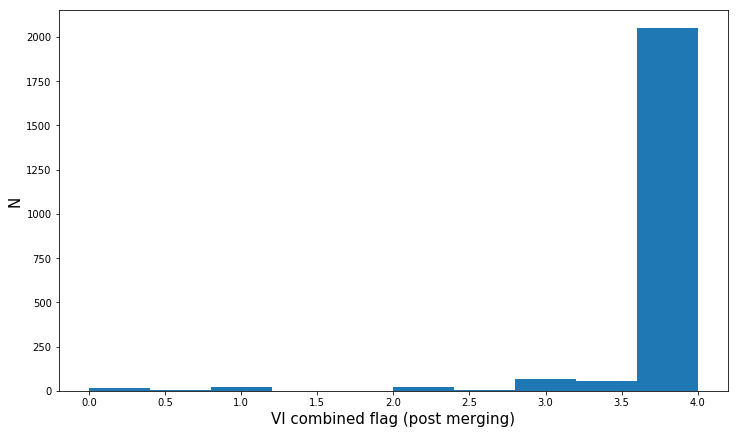

In [9]:
plt.figure(figsize=(12,7))
plt.hist(tt['best flag'])
plt.xlabel('VI combined flag (post merging)', fontsize=fs)
plt.ylabel('N', fontsize=fs)

In [10]:
good = tt[tt['best flag'] >=2.5]
print(len(good))

2181


In [11]:
bgs = tt[(tt['best flag'] >=2.5) & (tt['best spectype']=='GALAXY')]
print(len(bgs))

2162


In [12]:
print('fraction of secure redshifts: ',len(good)/len(tt))
print('fraction of secure galaxy redshifts: ',len(bgs)/len(tt))

fraction of secure redshifts:  0.9732262382864793
fraction of secure galaxy redshifts:  0.9647478804105311


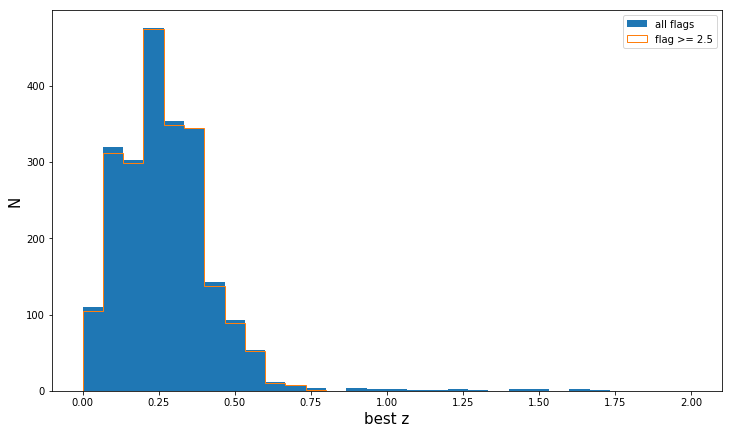

In [13]:
plt.figure(figsize=(12,7))
plt.hist(tt['best z'], label='all flags', range=(0,2), bins=30)
plt.hist(good['best z'], label = 'flag >= 2.5', range=(0,2), bins=30, histtype='step', lw=1)
plt.xlabel('best z', fontsize=fs)
plt.ylabel('N', fontsize=fs)
plt.legend()

## Looking at the failures in more detail

We define **secure failures** as objects for which redrock got the wrong redshift, but VI provides a secure redshift.

We define **not secure failures** as objects for which redrock (probably) got the wrong redshift, and for which inspectors attempted an alternative redshift, but with low confidence.

We can then inspect each of these sets in a dedicated prospect window.

(below, we will also look at all spectra with poor VI flags)

Text(0,0.5,'Redrock z')

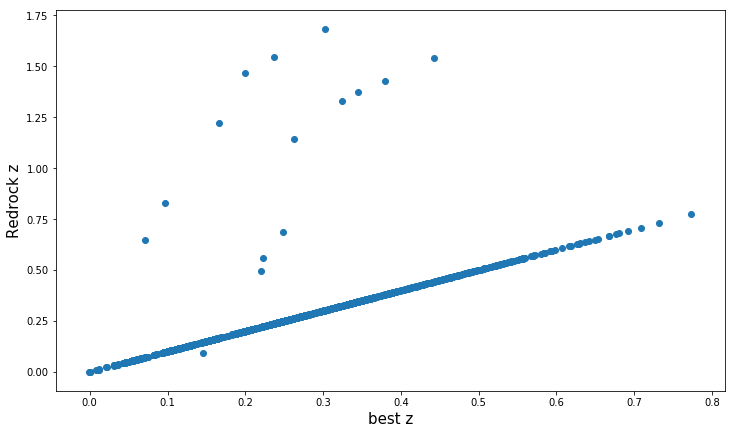

In [15]:
plt.figure(figsize=(12,7))
plt.scatter(good['best z'],good['Redrock z'] )
plt.xlabel('best z', fontsize=fs)
plt.ylabel('Redrock z', fontsize=fs)

In [16]:
fail_secure = tt[(np.abs(tt['dz'])>0.0033) & (tt['best flag']>=2.5)]

In [17]:
fail_secure

,Unnamed: 0,TARGETID,Redrock z,Redrock spectype,best z,best spectype,best flag,N_VI,all VI issue,all VI comments,...,FLUX_G,FLUX_R,FLUX_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,dz
140,140,35191341486966898,1.6827,GALAXY,0.3031,GALAXY,4.000000,4,R|R|R|RC,wrong line identification|--|--| Redrock reds...,...,3.903538,7.155365,8.521586,0.826716,1.515408,1.804755,0.943177,0.961359,0.978199,1.058706
160,160,35191344594944026,1.1448,GALAXY,0.2620,GALAXY,3.666667,3,R|RS|RC,Red contimuum shape very odd|Weird spectral sh...,...,2.842009,7.005595,11.872586,1.132619,2.791924,4.731554,0.950564,0.966424,0.981078,0.699525
180,180,35191344607528901,0.6461,GALAXY,0.0714,GALAXY,3.000000,3,R|R|R,--| Seems to be emission at 7000A but really n...,...,7.262138,10.740740,13.045255,0.579729,0.857422,1.041389,0.930024,0.952308,0.973036,0.536401
194,194,35191344611724629,1.5402,GALAXY,0.4428,GALAXY,3.666667,3,R|R|RC,OII fitted to Halpha|--| Wrong redshift fitte...,...,2.583140,7.848643,13.871878,0.501494,1.523747,2.693106,0.921773,0.946608,0.969774,0.760604
213,213,35191344620111451,0.0940,GALAXY,0.1456,GALAXY,4.000000,3,R|R|R,Redrock fit strong absorbtion with inverted O...,...,11.085628,20.642610,32.657917,1.888149,3.515934,5.562430,0.962743,0.974748,0.985796,-0.045042
302,302,35191344641082107,0.8312,GALAXY,0.0972,GALAXY,3.000000,2,--|RC,--| Wrong Redrock redshift - Halpha+NII +SII ...,...,4.512868,9.682252,15.063485,1.383877,2.969075,4.619237,0.947617,0.964405,0.979931,0.668976
468,468,35191347757451573,0.6855,GALAXY,0.2482,GALAXY,3.000000,3,R|--|--,Redrock redshift very wrong. z=0.24 is secure...,...,3.857276,8.787939,14.532964,0.997950,2.273605,3.759951,0.957141,0.970924,0.983630,0.350344
726,726,35191350878014538,1.2233,GALAXY,0.1663,GALAXY,3.000000,3,--|R|RCS,--|--|Redrock wrong redshift - redshift from H...,...,4.396598,6.924174,10.218941,0.639841,1.007682,1.487172,0.958673,0.971970,0.984223,0.906285
924,924,35191331831678391,1.4294,GALAXY,0.3801,GALAXY,3.000000,3,R|--|--,Misclassified Halpha as OII?|incomplete spectr...,...,2.675169,7.957931,16.753036,0.938533,2.791892,5.877492,0.961419,0.973845,0.985285,0.760307
1102,1102,35191335061293300,0.5589,GALAXY,0.2223,GALAXY,3.000000,3,--|RS|RS,Redrock redshift very wrong - clear H+K and H...,...,26.196140,69.020294,124.886450,3.008784,7.927394,14.343959,0.957610,0.971244,0.983812,0.275382


In [18]:
fail_not_secure = tt[(np.abs(tt['dz'])>0.0033) & (tt['best flag']<2.5)]

In [19]:
fail_not_secure

,Unnamed: 0,TARGETID,Redrock z,Redrock spectype,best z,best spectype,best flag,N_VI,all VI issue,all VI comments,...,FLUX_G,FLUX_R,FLUX_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,dz
134,134,35191341486965881,0.4640,GALAXY,0.0913,GALAXY,1.0,4,--|--|R|RC,--|--|--| Weak lines Halpha+NII - low surface ...,...,7.868326,12.031116,16.386139,0.597188,0.913134,1.243671,0.955933,0.970098,0.983162,0.341519
159,159,35191341491162469,0.5119,GALAXY,0.3136,GALAXY,1.0,3,R|R|--,inverted OII and OIII fitted to absorbtion fe...,...,5.475584,11.674562,16.657534,0.720621,1.536445,2.192235,0.949827,0.965920,0.980792,0.150959
358,358,35191347736478218,1.3463,GALAXY,0.0083,GALAXY,2.0,3,R|--|R,Target outer part of very elongated local blu...,...,4.353954,6.260717,11.105669,0.155392,0.223445,0.396361,0.953203,0.968231,0.982104,1.326986
510,510,35191347770032748,0.5173,GALAXY,0.1240,GALAXY,1.0,3,--|RCS|--,i'm no expert but the shape of the spectrum l...,...,4.526299,7.890365,10.172826,0.626472,1.092083,1.407992,0.963606,0.975336,0.986128,0.349911
685,685,35191350869626616,0.6054,GALAXY,0.7446,GALAXY,1.0,3,--|--|--,not really any features visible|--| Based onl...,...,2.062953,6.428900,16.660295,0.355719,1.108549,2.872769,0.955529,0.969822,0.983006,-0.079789
761,761,35191325330507556,0.3928,GALAXY,0.4961,GALAXY,2.0,12,R|--|--|--|--|--|C|--|R|--|--|--,--|--|--|--|--| LRG but poor match to template...,...,1.866225,7.630687,17.541020,0.614623,2.513090,5.776959,0.883664,0.920064,0.954468,-0.069046
1235,1235,35191335090651685,1.0280,GALAXY,0.1816,GALAXY,2.0,4,--|C|R|S,--| No clear features - low S?N|--|--,...,3.634022,6.800800,9.599903,0.819008,1.532713,2.163553,0.936817,0.956987,0.975708,0.716317
1440,1440,35191338303489270,0.0938,GALAXY,0.1850,GALAXY,2.0,3,R|--|--,0.1850 seems to fit better by eye|--| LRG,...,3.067767,6.954637,11.514951,1.198557,2.717132,4.498817,0.951925,0.967356,0.981607,-0.076962
1507,1507,35191350886400505,0.7130,GALAXY,1.1632,QSO,1.0,3,--|R|RC,only continuum (noisy though)|--| Very insecu...,...,3.505278,7.257621,10.792073,1.151233,2.383609,3.544423,0.962641,0.974679,0.985756,-0.208118
1588,1588,35191353944048312,0.6682,GALAXY,0.0121,GALAXY,1.0,3,--|--|--,Insecure redshift based on Halpha only - very...,...,24.680390,33.857315,41.720783,0.243880,0.334562,0.412265,0.923722,0.947956,0.970546,0.648256


## Looking at poor-quality spectra

More generally, we can look at ALL spectra with poor quality flags (for many of these, the redrock z will have been left untouched, and do not qualify as "failures")

In [20]:
not_secure = tt[tt['best flag']<2.5]

In [21]:
not_secure

,Unnamed: 0,TARGETID,Redrock z,Redrock spectype,best z,best spectype,best flag,N_VI,all VI issue,all VI comments,...,FLUX_G,FLUX_R,FLUX_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,dz
20,20,35191341457608318,0.1638,GALAXY,0.1638,GALAXY,1.000000,3,--|--|--,--|--| No clear features - low S/N,...,3.722557,9.701375,12.832011,0.181875,0.473986,0.626941,0.928600,0.951325,0.972474,0.000000
99,99,35191341478578997,1.2489,GALAXY,1.2489,GALAXY,0.000000,3,S|S|R,--| no signal| Just looks like noise,...,6.156144,8.173813,9.627413,2.497495,3.316046,3.905759,0.948792,0.965211,0.980389,0.000000
134,134,35191341486965881,0.4640,GALAXY,0.0913,GALAXY,1.000000,4,--|--|R|RC,--|--|--| Weak lines Halpha+NII - low surface ...,...,7.868326,12.031116,16.386139,0.597188,0.913134,1.243671,0.955933,0.970098,0.983162,0.341519
159,159,35191341491162469,0.5119,GALAXY,0.3136,GALAXY,1.000000,3,R|R|--,inverted OII and OIII fitted to absorbtion fe...,...,5.475584,11.674562,16.657534,0.720621,1.536445,2.192235,0.949827,0.965920,0.980792,0.150959
226,226,35191344628499060,0.1066,GALAXY,0.1066,GALAXY,0.333333,3,--|R|--,--| Just looks like noise and not clear anythi...,...,3.563022,6.162282,7.673811,0.065481,0.113249,0.141028,0.956900,0.970759,0.983537,0.000000
233,233,35191344628500337,0.1280,GALAXY,0.1280,GALAXY,2.333333,3,--|--|--,Possibly a 3 but in this case auto scaling of...,...,4.067128,9.650112,20.029457,1.010358,2.397286,4.975729,0.956171,0.970261,0.983255,0.000000
317,317,35191344645275686,0.7925,GALAXY,0.7925,GALAXY,0.500000,2,S|--,low signal to noise| No signal,...,10.932622,19.901615,29.807198,3.534929,6.434942,9.637790,0.944510,0.962274,0.978719,0.000000
331,331,35191344645277997,1.0878,QSO,1.0878,QSO,0.500000,2,S|--,low signal to noise|No signal,...,20.861140,34.852550,51.546997,2.492058,4.163463,6.157772,0.947611,0.964401,0.979929,0.000000
358,358,35191347736478218,1.3463,GALAXY,0.0083,GALAXY,2.000000,3,R|--|R,Target outer part of very elongated local blu...,...,4.353954,6.260717,11.105669,0.155392,0.223445,0.396361,0.953203,0.968231,0.982104,1.326986
493,493,35191347765839071,5.3837,QSO,5.3837,QSO,1.000000,3,RCS|S|--,Very poor spectrum. Target on outskirts of di...,...,10.913124,15.460363,16.975466,0.492267,0.697383,0.765726,0.960166,0.972990,0.984801,0.000000


## Looking at delta_chi2

Text(0,0.5,'normalised distribution')

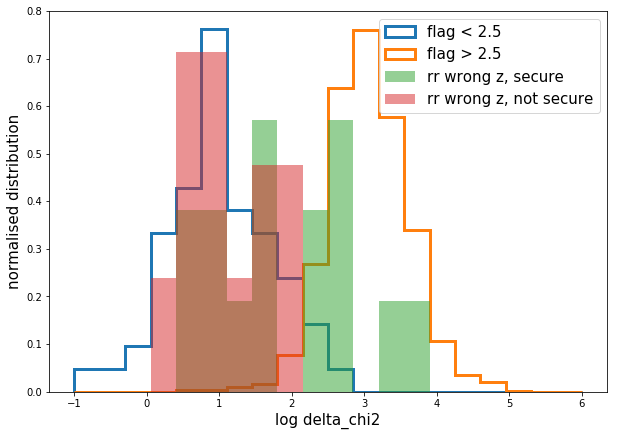

In [22]:
range=(-1,6)
plt.figure(figsize=(10,7))
plt.hist(np.log10(not_secure['DELTACHI2']), label='flag < 2.5', histtype='step', normed=True, lw=3, range=range, bins=20)
plt.hist(np.log10(good['DELTACHI2']), label='flag > 2.5', histtype='step', normed=True, lw=3, range=range, bins=20)
plt.hist(np.log10(fail_secure['DELTACHI2']), label='rr wrong z, secure', normed=True, alpha=0.5, range=range, bins=20)
plt.hist(np.log10(fail_not_secure['DELTACHI2']), label='rr wrong z, not secure', alpha=0.5, normed=True, range=range, bins=20)
plt.legend(fontsize=fs)
plt.xlabel('log delta_chi2', fontsize=fs)
plt.ylabel('normalised distribution', fontsize=fs)